In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from PIL import Image
import time
import os
import time
import pdb
import glob

# proxyの設定．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader


from torch.autograd import Variable
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import datasets

In [2]:
vgg16 = models.vgg16(pretrained=True,progress=True)
softmax=nn.Softmax(dim=1)
# pretrained=True とすると，学習済みポラメータも読み込まれる．
# ~/.cache/torch/checkpoints/ に読み込まれます．VGG16は550MBもあるので，不要になったら消去しましょう．
# ls でダウンロードされていることを確認してみます．
! ls -l ~/.cache/torch/checkpoints/ 

total 1206624
-rw------- 1 yamamoto-k YANAI_LAB 102502400 Apr 27 18:13 resnet50-19c8e357.pth
-rw------- 1 yamamoto-k YANAI_LAB   4966400 Apr 29 20:54 squeezenet1_1-f364aa15.pth
-rw------- 1 yamamoto-k YANAI_LAB 553433881 Apr 25 19:43 vgg16-397923af.pth
-rw------- 1 yamamoto-k YANAI_LAB 574673361 Apr 29 13:53 vgg19-dcbb9e9d.pth


In [3]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.reshape(input.size(0), -1)
    
vgg16fc7 = torch.nn.Sequential(
    vgg16.features,
    vgg16.avgpool,
    Flatten(),
    *list(vgg16.classifier.children())[:-3]  # 最後の3つのlayer(relu,dropout,fc1000)を削除
)

In [5]:
imglist=glob.glob('ramen/img00*.jpg')+glob.glob('ramen/img01*.jpg')

in_size=224
imgs = np.empty((0,in_size,in_size,3), dtype=np.float32)

for i,img_path in enumerate(imglist):
    if i%100==0:
        print("reading {}th image".format(i))
    x = np.array(Image.open(img_path).resize((in_size,in_size)), dtype=np.float32)
    x = np.expand_dims(x, axis=0)
    imgs = np.vstack((imgs,x))
    
mean=np.array([0.485, 0.456, 0.406], dtype=np.float32)
std=np.array([0.229, 0.224, 0.225], dtype=np.float32)
imgs=(imgs/255.0-mean)/std
imgs=imgs.transpose(0,3,1,2)  # HWC -> CHW
img=torch.from_numpy(imgs)
print(imgs.shape)

reading 0th image
reading 100th image
(200, 3, 224, 224)


In [6]:
# 200枚処理するので，GPUを使います．
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
vgg16fc7 = vgg16fc7.to(device)

cuda


In [7]:
vgg16fc7.eval()
with torch.no_grad():
    fc=vgg16fc7(img.to(device)).cpu().numpy()
print(fc.shape)

(200, 4096)


In [13]:
def imshow(img):
    img  = np.transpose(img, (1, 2, 0))
    mean=np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std=np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img = (img*std + mean)
    plt.imshow(img) 

In [9]:
pca_95 = PCA(n_components=0.95)
pca_95.fit(fc)
transformed_95 = pca_95.fit_transform(fc)

pca_90 = PCA(n_components=0.90)
pca_90.fit(fc)
transformed_90 = pca_90.fit_transform(fc)

pca_128 = PCA(n_components=128)
pca_128.fit(fc)
transformed_128 = pca_128.fit_transform(fc)

In [21]:
print(fc.shape)
print(transformed_95.shape)
print(transformed_90.shape)
print(transformed_128.shape)

(200, 4096)
(200, 61)
(200, 38)
(200, 128)


### k=5の時

In [10]:
k = 5

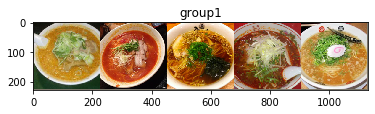

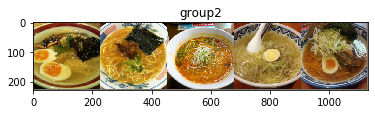

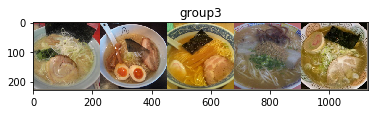

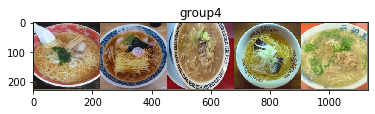

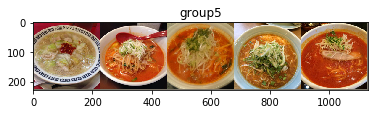

In [14]:
kmeans_model_k5 = KMeans(n_clusters=k).fit_predict(fc)
for i in range(k):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(img[kmeans_model_k5 == i][0:5].cpu()).numpy())
    plt.show()

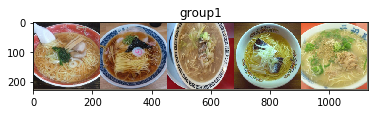

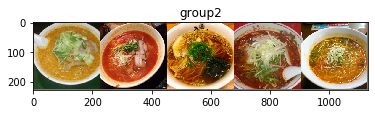

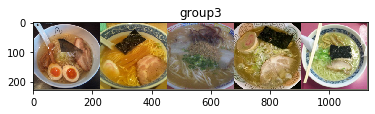

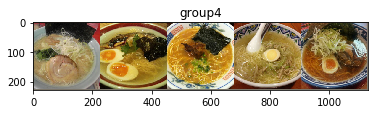

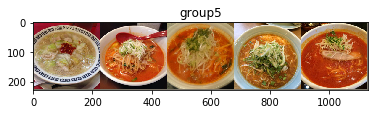

In [16]:
kmeans_model_k5 = KMeans(n_clusters=k).fit_predict(transformed_95)
for i in range(k):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(img[kmeans_model_k5 == i][0:5].cpu()).numpy())
    plt.show()

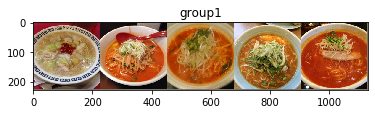

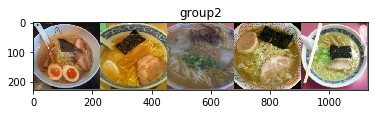

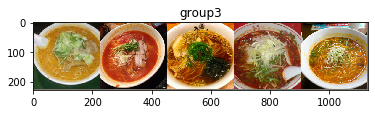

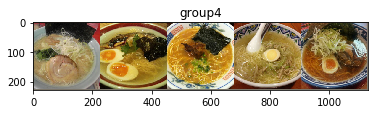

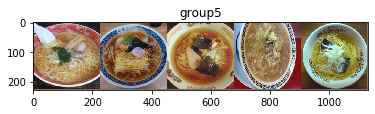

In [17]:
kmeans_model_k5 = KMeans(n_clusters=k).fit_predict(transformed_90)
for i in range(k):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(img[kmeans_model_k5 == i][0:5].cpu()).numpy())
    plt.show()

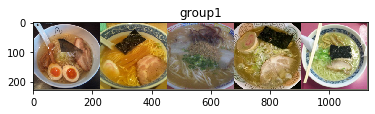

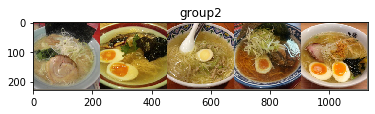

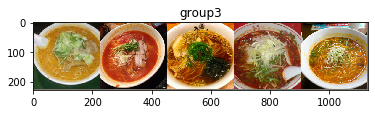

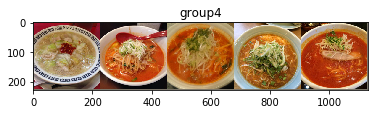

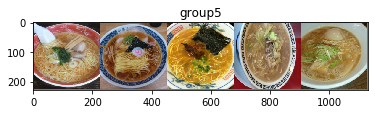

In [18]:
kmeans_model_k5 = KMeans(n_clusters=k).fit_predict(transformed_128)
for i in range(k):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(img[kmeans_model_k5 == i][0:5].cpu()).numpy())
    plt.show()

### k=10の時

In [22]:
k = 10

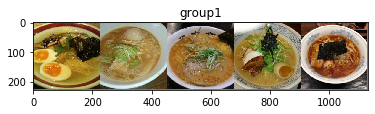

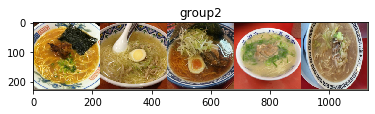

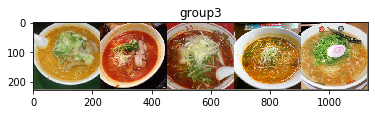

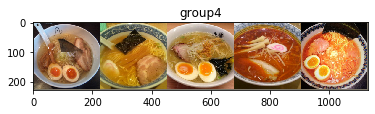

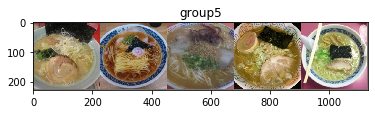

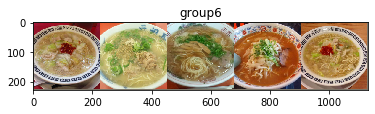

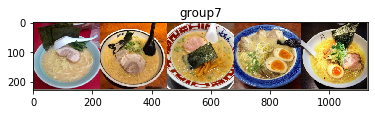

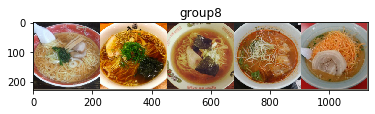

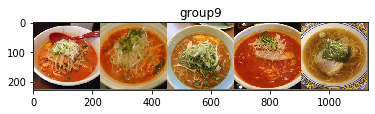

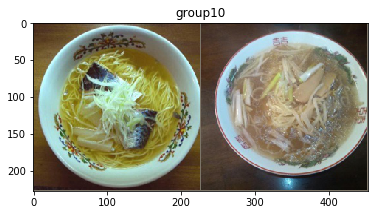

In [23]:
kmeans_model_k10 = KMeans(n_clusters=k).fit_predict(fc)
for i in range(k):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(img[kmeans_model_k10 == i][0:5].cpu()).numpy())
    plt.show()

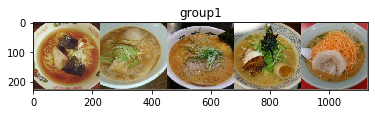

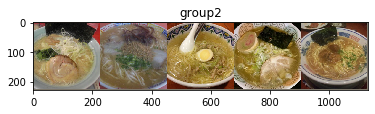

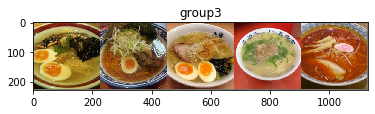

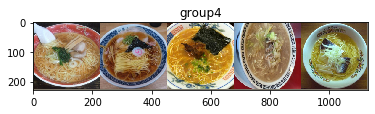

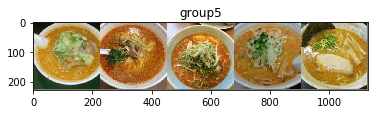

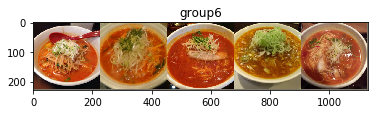

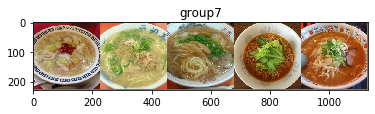

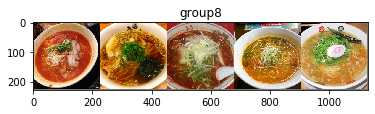

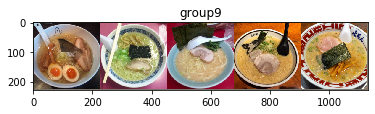

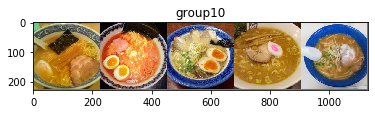

In [24]:
kmeans_model_k10 = KMeans(n_clusters=k).fit_predict(transformed_95)
for i in range(k):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(img[kmeans_model_k10 == i][0:5].cpu()).numpy())
    plt.show()

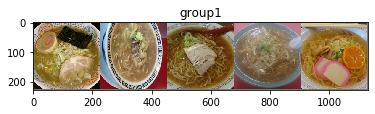

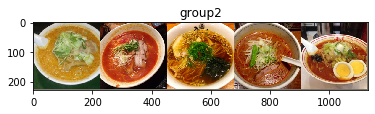

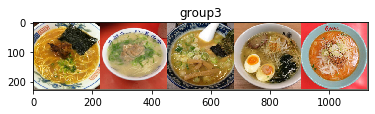

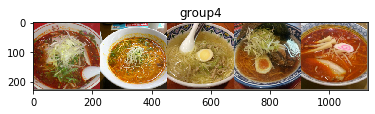

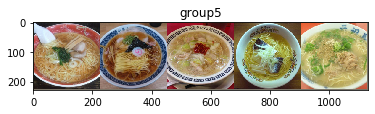

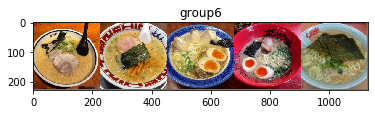

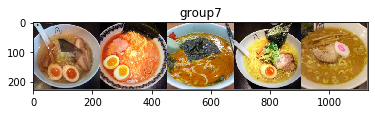

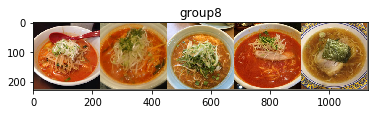

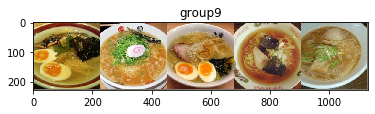

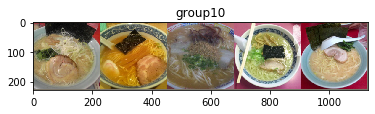

In [25]:
kmeans_model_k10 = KMeans(n_clusters=k).fit_predict(transformed_90)
for i in range(k):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(img[kmeans_model_k10 == i][0:5].cpu()).numpy())
    plt.show()

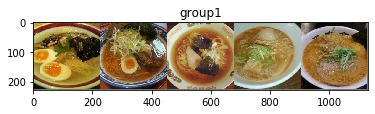

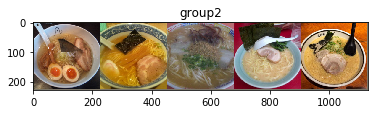

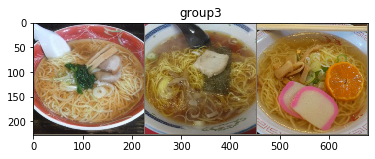

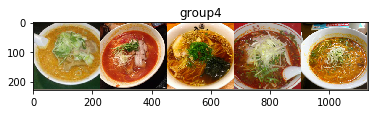

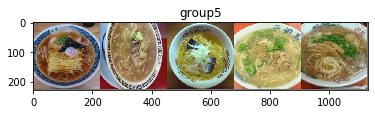

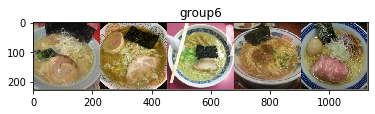

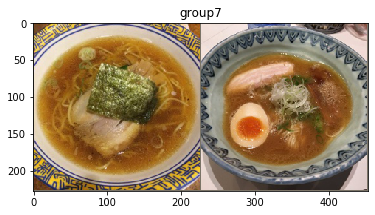

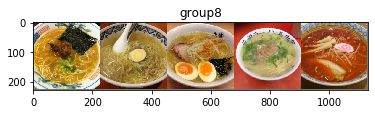

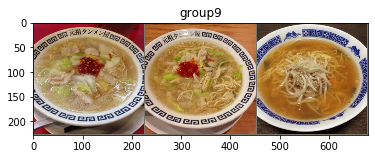

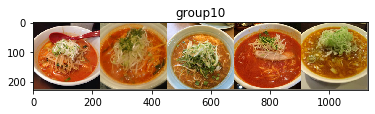

In [26]:
kmeans_model_k10 = KMeans(n_clusters=k).fit_predict(transformed_128)
for i in range(k):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(img[kmeans_model_k10 == i][0:5].cpu()).numpy())
    plt.show()

sklearn.decomposition.PCAは次元数の少ない方を圧縮するので、4096次元と１００枚を比較した時１００枚を圧縮するようになるので、問題文をそのまま実行することはできなかった。<br>
同じラーメンの画像にしてしまったので、区別がわかりづらくなってしまったように思う。次元数やkを変化させてもどこがどう変わったかは説明しづらい。（卵の有無、チャーシューの有無、赤みが強いスープかどうかなどが区別の対象になっているようには思う。）<br>
これもDNNを使わない計算手法なので、素早く計算を行うことができ、数的処理をする際には便利な手法だと感じた。

### 参考
https://www.takapy.work/entry/2019/02/08/002738 <br>
https://blog.amedama.jp/entry/2017/04/02/130530 <br>
https://www.yakupro.info/entry/ml-pca